# Import modules and load data

In [2]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [1]:
import mysql.connector
import pandas as pd
import numpy as np
import pickle 

import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn import model_selection
import xgboost as xgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV
from collections import Counter
import pickle
import operator
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import make_scorer
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import time
acc = make_scorer(accuracy_score)


from sklearn.multiclass import OneVsRestClassifier

/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
import random

def sampleData(DataFrame, ratio):
    df_size = len(DataFrame.index)
    sample_size = int(round(ratio * df_size))
    if sample_size == df_size:
        sample_size = sample_size - 1
        indexes = random.sample(range(df_size), sample_size)
        sample = DataFrame.iloc[indexes, : ]
        return sample

    elif sample_size == 0:
        sample_size = 1
        indexes = random.sample(range(df_size), sample_size)
        sample = DataFrame.iloc[indexes, : ]
        return sample

    else:
        indexes = random.sample(range(df_size), sample_size)
        sample = DataFrame.iloc[indexes, : ]
        return sample

In [3]:
#import data
atlas = pd.read_csv('/home/compomics/git/MLMarker/data/tissue_predictor_filtered_healthy_nofluid_2206.csv', sep="/")
#replace zeroes with np.nan

exclude_tissues = ['Dental plaque', 'hMSC', 'Hela', 'Unknown', 'Urine', 'Cerebrospinal fluid', 'Tooth', 'Bone', 'Eye', 'Cartilage', 'Microvessel', 'Nasal polyps', 'Nasal Polyps']
atlas = atlas[~atlas['tissue_name'].isin(exclude_tissues)]
atlas = atlas.replace({'Cervix': 'Uterine cervix'})
atlas = atlas.replace({'Palatine tonsils': 'Tonsil'})
atlas = atlas.replace({'palatine tonsils': 'Tonsil'})
atlas = atlas.replace({'B-cell': 'B-cells'})
atlas = atlas.replace({'Nasal polyps': 'Nasal Polyps'})
atlas = atlas.replace({'Monocyte': 'Monocytes'})
#drop columns with only zeroes
atlas = atlas.loc[:, (atlas != 0).any(axis=0)]
print(atlas.shape)
filtered_features = list(atlas.columns)

(2122, 4075)


In [4]:
atlas.head()

,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6K4,A0A0A0MS14,A0A0A0MS15,A0A0B4J1U7,A0A0C4DH25,A0A0C4DH30,...,Q9Y6V0,Q9Y6W3,Q9Y6W5,Q9Y6X5,Q9Y6X8,Q9Y6X9,Q9Y6Y8,cell_type,tissue_name,disease_status
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Brain,Brain,Healthy
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Brain,Brain,Healthy
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Brain,Brain,Healthy
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Brain,Brain,Healthy
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Brain,Brain,Healthy


## Drop projects with too many missing values and with less than 2 PXDs associated with it

In [6]:
# Calculate the percentage of zero values per row
zero_percentage = (atlas.iloc[:, :-1].eq(0).sum(axis=1) / atlas.iloc[:, :-1].shape[1]) * 100

# Add the "tissue_name" column to the "zero_percentage" dataframe
zero_percentage = pd.concat([atlas['tissue_name'], zero_percentage], axis=1)
zero_percentage.columns = ['tissue_name', 'zero_percentage']


In [7]:
#make a standard distribution of all values in zero_percentage
#get the mean, std and count of the zero_percentage
mean = zero_percentage['zero_percentage'].mean()
std = zero_percentage['zero_percentage'].std()
count = zero_percentage['zero_percentage'].count()
upper_bound = mean + 1*std
lower_bound = mean - 1*std
print(mean, std, upper_bound, lower_bound)

90.55837644481892 7.912612323000385 98.4709887678193 82.64576412181853


/tmp/ipykernel_66257/3601340492.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=zero_percentage.sort_values(by='tissue_name'), x='tissue_name', y='zero_percentage', palette='Set1')


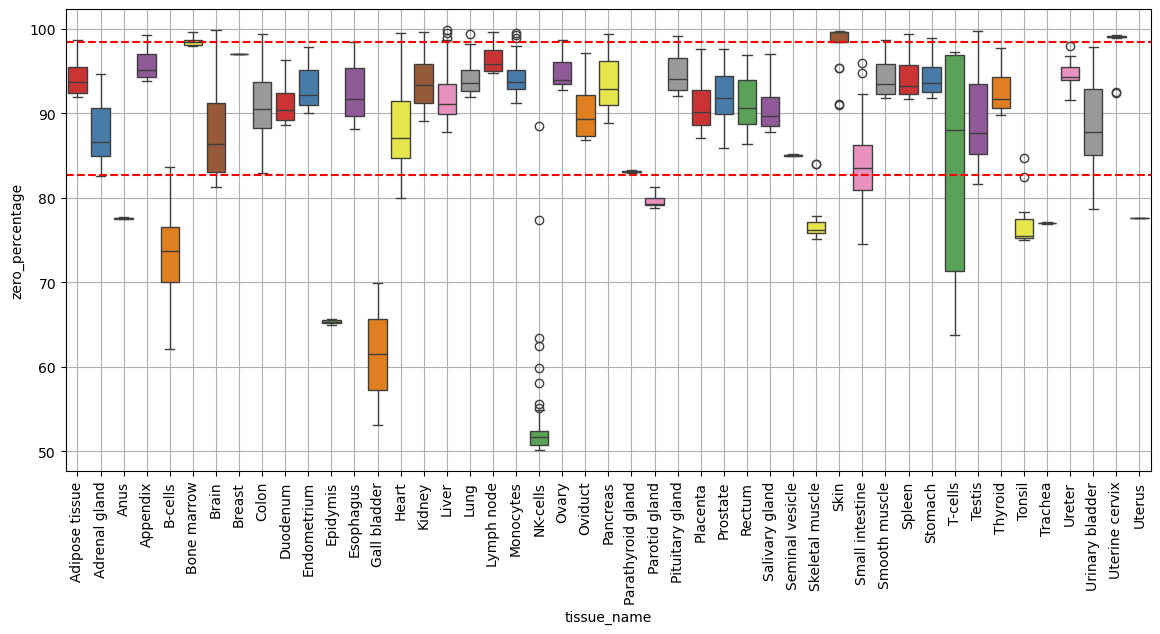

In [9]:
plt.figure(figsize=(14, 6))  # Adjust the figsize as per your preference
sns.boxplot(data=zero_percentage.sort_values(by='tissue_name'), x='tissue_name', y='zero_percentage', palette='Set1')
plt.xticks(rotation=90)  # Rotate the xlabels for better visibility
plt.grid(True)  # Add grid

# Add horizontal lines on upper and lower bounds
plt.axhline(upper_bound, color='red', linestyle='--')
plt.axhline(lower_bound, color='red', linestyle='--')

plt.show()


In [10]:
#drop the rows that contain over 95% missingness and then drop all columns that only contain NaN values
zero_percentage = (atlas.iloc[:, :-1].eq(0).sum(axis=1) / atlas.iloc[:, :-1].shape[1]) * 100
atlas = atlas[zero_percentage < upper_bound]
atlas = atlas[zero_percentage > lower_bound]
#drop the rows in atlas that are tissue_name == Testis and zero_percentage < 88
# atlas = atlas[~((atlas['tissue_name'] == 'Testis') & (zero_percentage < 86))]

atlas = atlas.loc[:, (atlas != 0).any(axis=0)]
atlas.dropna(axis=1, how='all')
atlas.shape

/tmp/ipykernel_66257/1716695017.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  atlas = atlas[zero_percentage > lower_bound]


(1810, 2652)

## Check the class balance

<Axes: ylabel='count'>

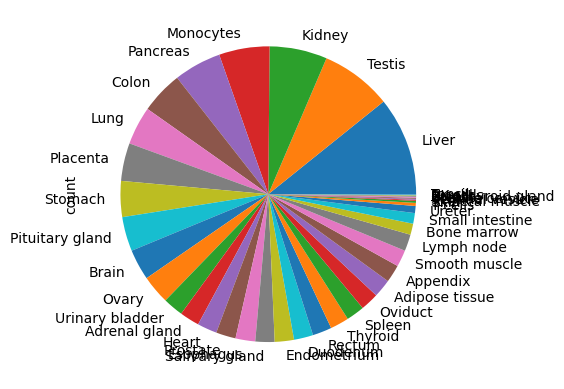

In [11]:
atlas['tissue_name'].value_counts().plot.pie()

We will balance the atlas a little bit by dropping the tissues that are too low. 

In [12]:
pd.set_option('display.max_rows', None)  
tissue_counts = atlas['tissue_name'].value_counts().to_frame()
print(tissue_counts)

                   count
tissue_name             
Liver                195
Testis               141
Kidney               114
Monocytes            100
Pancreas              94
Colon                 84
Lung                  76
Placenta              75
Stomach               71
Pituitary gland       68
Brain                 61
Ovary                 57
Urinary bladder       40
Adrenal gland         39
Heart                 39
Prostate              39
Esophagus             39
Salivary gland        38
Endometrium           38
Duodenum              38
Rectum                38
Thyroid               37
Spleen                36
Oviduct               36
Adipose tissue        36
Appendix              35
Smooth muscle         33
Lymph node            33
Bone marrow           22
Small intestine       21
Ureter                14
T-cells                6
Skin                   4
Skeletal muscle        2
Seminal vesicle        2
Uterine cervix         2
Breast                 2
Parathyroid gland      2


# Drop low tissues

In [13]:
low_tissues = tissue_counts.reset_index()[tissue_counts.reset_index()['count'] <= 2]['tissue_name'].tolist()
atlas = atlas[~atlas['tissue_name'].isin(low_tissues)]

In [14]:
tf = dict(Counter(atlas['tissue_name']))
tf = sorted(tf.items(), key=operator.itemgetter(1), reverse=True)
tf = dict(tf)

/tmp/ipykernel_66257/3203325865.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=zero_percentage.sort_values(by='tissue_name'), x='tissue_name', y='zero_percentage', palette='Set1')


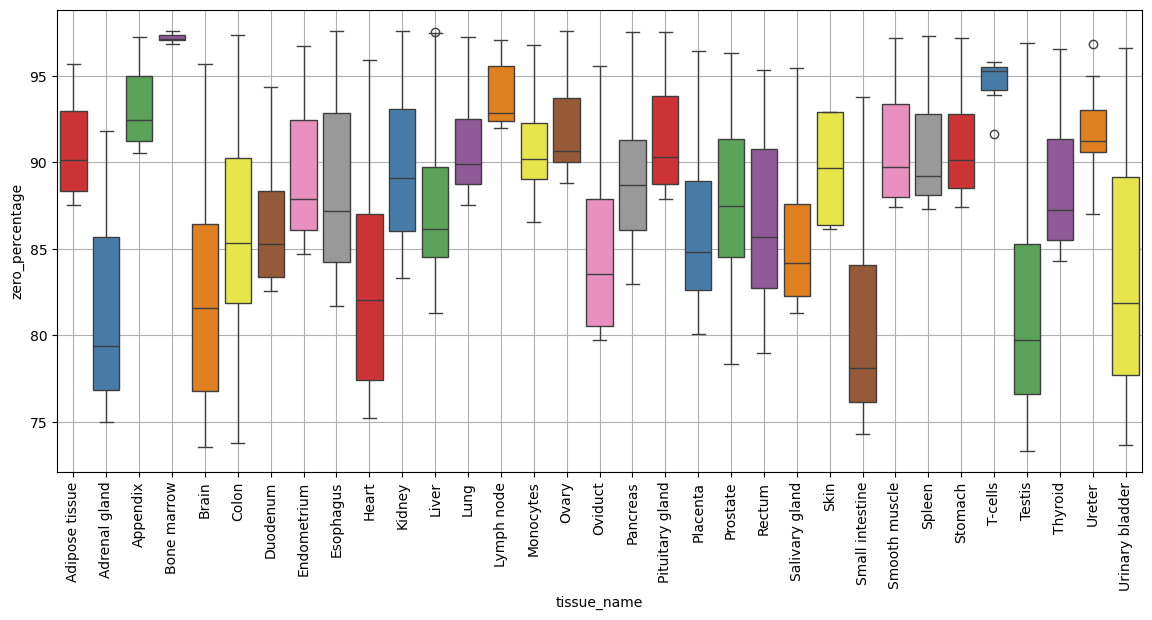

In [15]:
# Calculate the percentage of zero values per row
zero_percentage = (atlas.iloc[:, :-1].eq(0).sum(axis=1) / atlas.iloc[:, :-1].shape[1]) * 100

# Add the "tissue_name" column to the "zero_percentage" dataframe
zero_percentage = pd.concat([atlas['tissue_name'], zero_percentage], axis=1)
zero_percentage.columns = ['tissue_name', 'zero_percentage']

plt.figure(figsize=(14, 6))  # Adjust the figsize as per your preference
sns.boxplot(data=zero_percentage.sort_values(by='tissue_name'), x='tissue_name', y='zero_percentage', palette='Set1')
plt.xticks(rotation=90)  # Rotate the xlabels for better visibility
plt.grid(True)  # Add grid
plt.show()


In [16]:
#drop nasal polyps and bone marrow
atlas = atlas[atlas['tissue_name'] != 'Nasal Polyps']
atlas = atlas[atlas['tissue_name'] != 'Bone marrow']


# Using class weight in the predictors <br>
To further balance the algorithm, the class will be assigned a specific weight based on the number of samples in this class. 

The weight of a class is determined by dividing negative samples/ positive samples. So if a class contains 15 samples in a dataset of 100 samples, the class weight will be 85/15=5,667

In [17]:
#drop cell_type and disease_status
atlas = atlas.drop(['cell_type', 'disease_status'], axis=1)

In [18]:
binary_atlas = atlas.copy()
binary_atlas = atlas.copy()
binary_atlas.iloc[:, :-1] = binary_atlas.iloc[:, :-1].applymap(lambda x: 1 if x != 0 else x)
binary_atlas = binary_atlas.loc[(binary_atlas.iloc[:, :-1] != 0).any(axis=1)] #remove rows with all zeros
X = binary_atlas.iloc[:, :-1]
y = binary_atlas[['tissue_name']]
train_df = pd.DataFrame()
test_df = pd.DataFrame()
validation_df = pd.DataFrame()

tissues = binary_atlas['tissue_name'].unique()
DataFrameDict = {elem : pd.DataFrame for elem in tissues}
for key in DataFrameDict.keys():
    DataFrameDict[key] = binary_atlas[:][binary_atlas['tissue_name'] == key]

for key in DataFrameDict.keys():
    train = sampleData(DataFrameDict[key], 0.80)
    train_df = pd.concat([train_df, train], ignore_index=True)

    test = DataFrameDict[key].drop(train.index)
    test_df = pd.concat([test_df, test], ignore_index=True)

y_train = train_df.pop('tissue_name').values
X_train = train_df.values
y_test = test_df.pop('tissue_name').values
X_test = test_df.values

X_train = pd.DataFrame(X_train, columns=(binary_atlas.columns)[:-1])
X_test = pd.DataFrame(X_test, columns=(binary_atlas.columns)[:-1])
result_df = pd.DataFrame(columns=['model','Accuracy', 'f1_macro', 'precision_macro', 'recall_macro', 'f1_weighted', 'precision_weighted', 'recall_weighted'])
train = pd.merge(pd.DataFrame(X_train), pd.DataFrame(y_train), left_index=True, right_index=True)
train.head()

/tmp/ipykernel_66257/2371067337.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  binary_atlas.iloc[:, :-1] = binary_atlas.iloc[:, :-1].applymap(lambda x: 1 if x != 0 else x)


,A0A075B6H7,A0A075B6I0,A0A0A0MS15,A0A0B4J1U7,A0A0C4DH38,A0AVT1,A0MZ66,A1L4H1,A3KMH1,A3KN83,...,Q9Y6N6,Q9Y6N9,Q9Y6Q1,Q9Y6R1,Q9Y6U3,Q9Y6V0,Q9Y6W5,Q9Y6X5,Q9Y6Y8,0
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,Brain
1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,Brain
2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,Brain
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Brain
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Brain


In [137]:
# binary_atlas.to_csv("/home/compomics/git/MLMarker/models/atlas_binary_TP_4000features_95to75missingness_2024.csv", index=False)
# train.to_csv("/home/compomics/git/MLMarker/models/train_binary_TP_4000features_95to75missingness_2024.csv", index=False)



# XGBoost

In [67]:
from sklearn.preprocessing import LabelEncoder
# Fit LabelEncoder on y_train
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Fit XGBoost model
xgb = XGBClassifier(random_state=42, n_jobs=-1)
xgb.fit(X_train, y_train_encoded, sample_weight=weights)

# Predict on X_test
baseline_predictions_encoded = xgb.predict(X_test)

# Decode the predictions
baseline_predictions = label_encoder.inverse_transform(baseline_predictions_encoded)

# Calculate evaluation metrics
fm = f1_score(y_test, baseline_predictions, average="macro")
fw = f1_score(y_test, baseline_predictions, average="weighted")
acc = accuracy_score(y_test, baseline_predictions)
pw = precision_score(y_test, baseline_predictions, average='weighted')
pm = precision_score(y_test, baseline_predictions, average='macro')
rw = recall_score(y_test, baseline_predictions, average='weighted')
rm = recall_score(y_test, baseline_predictions, average='macro')

# Update result_df
df_length = len(result_df)
result_df.loc[df_length] = ['XGB_baseline', acc, fm, pm, rm, fw, pm, rw]

/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [86]:
from sklearn.preprocessing import LabelEncoder
# Fit LabelEncoder on y_train
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Fit XGBoost model
xgb = XGBClassifier(random_state=42, n_jobs=-1, alpha=1, colsample_bytree=0.1, eta=0.1, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8)
xgb.fit(X_train, y_train_encoded)

# Predict on X_test
baseline_predictions_encoded = xgb.predict(X_test)

# Decode the predictions
baseline_predictions = label_encoder.inverse_transform(baseline_predictions_encoded)

# Calculate evaluation metrics
fm = f1_score(y_test, baseline_predictions, average="macro")
fw = f1_score(y_test, baseline_predictions, average="weighted")
acc = accuracy_score(y_test, baseline_predictions)
pw = precision_score(y_test, baseline_predictions, average='weighted')
pm = precision_score(y_test, baseline_predictions, average='macro')
rw = recall_score(y_test, baseline_predictions, average='weighted')
rm = recall_score(y_test, baseline_predictions, average='macro')

# Update result_df
df_length = len(result_df)
result_df.loc[df_length] = ['XGB_baseline_noweights', acc, fm, pm, rm, fw, pm, rw]

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [97]:
label_encoder.classes_[[21, 11, 15, 6, 4]]

array(['Tonsil', 'NK-cells', 'Prostate', 'Esophagus', 'Brain'],
      dtype=object)

In [87]:
result_df

,model,Accuracy,f1_macro,precision_macro,recall_macro,f1_weighted,precision_weighted,recall_weighted
0,XGB_baseline,0.958333,0.940476,0.937500,0.947917,0.949405,0.937500,0.958333
1,XGB_baseline_noweights,0.958333,0.940476,0.937500,0.947917,0.949405,0.937500,0.958333
2,XGB_baseline_noweights,0.958333,0.940476,0.937500,0.947917,0.949405,0.937500,0.958333
3,XGB_baseline_noweights,0.958333,0.940476,0.937500,0.947917,0.949405,0.937500,0.958333
4,XGB_baseline_noweights,0.854167,0.677880,0.659821,0.708333,0.801363,0.659821,0.854167


In [88]:
# Save model using XGBoost’s native save_model method
xgb.save_model("/home/compomics/git/MLMarker/models/binary_TP_XGB_95to75missingness_2024.json")


In [84]:
xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [83]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
# Fit LabelEncoder on y_train
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Fit XGBoost model
xgb = XGBClassifier(random_state=42, n_jobs=-1)
xgb.fit(X_train, y_train_encoded)

# Predict on X_test
baseline_predictions_encoded = xgb.predict(X_test)

# Decode the predictions
baseline_predictions = label_encoder.inverse_transform(baseline_predictions_encoded)

# Calculate evaluation metrics
fm = f1_score(y_test, baseline_predictions, average="macro")
fw = f1_score(y_test, baseline_predictions, average="weighted")
acc = accuracy_score(y_test, baseline_predictions)
pw = precision_score(y_test, baseline_predictions, average='weighted')
pm = precision_score(y_test, baseline_predictions, average='macro')
rw = recall_score(y_test, baseline_predictions, average='weighted')
rm = recall_score(y_test, baseline_predictions, average='macro')

# Update result_df
df_length = len(result_df)
result_df.loc[df_length] = ['XGB_baseline_noweights', acc, fm, pm, rm, fw, pm, rw]

import shap
explainer = shap.Explainer(xgb)



Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_81630/1313519035.py", line 31, in <module>
    explainer = shap.Explainer(xgb)
  File "/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/shap/explainers/_explainer.py", line 171, in __init__
TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              m

In [89]:
# Save the model as joblib file and save the feature names
from joblib import dump
import numpy as np

dump(xgb, "/home/compomics/git/MLMarker/models/binary_TP_XGB_95to75missingness_2024.joblib")
# np.savetxt('/home/compomics/git/MLMarker/models/binary_features_TP_XGB_95to75missingness_2024.txt', X_train.columns, fmt='%s')

['/home/compomics/git/MLMarker/models/binary_TP_XGB_95to75missingness_2024.joblib']

In [71]:
X_train.shape

(181, 6877)

In [ ]:
num_classes =len(np.unique(y_train))
print(num_classes)

25


In [ ]:
#optimize XGBoost using STratifiedkfold cross validation
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.01,0.1,0.2,0.4,0.6, 0.8, 1.0],
        'colsample_bytree': [0.01,0.1,0.2,0.4,0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
        'eta':[0.01,0.001, 0.05,0.1],
        'n_estimators': [100, 200, 300, 400, 500,1000],
        'alpha':[0,0.1,1],
        'lambda':[1,2,3,5,8]
        }
# Initialize XGB and GridSearch
xgb = XGBClassifier(random_state=42, n_jobs=-1,  object='multi:softprob', eval_metric='mlogloss', num_class=num_classes)
grid = RandomizedSearchCV(xgb, params, n_jobs=-1, cv=5, verbose=3)
# Run the grid
grid.fit(X_train, y_train, sample_weight=weights)
# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)
best_params = grid.best_params_
best_params

In [ ]:
result_df

,model,Accuracy,f1_macro,precision_macro,recall_macro,f1_weighted,precision_weighted,recall_weighted
0,XGB_baseline,0.914286,0.751811,0.750188,0.769919,0.890168,0.750188,0.914286
1,XGB_baseline_noweights,0.914286,0.751811,0.750188,0.769919,0.890168,0.750188,0.914286


# RandomForest

Addressing zero features: adjust sample weight based on non-zero features

In [19]:
# Assuming X is your feature matrix and y is your target class labels

# Calculate sample weights based on the number of non-zero features per sample
# Assign more weight to samples with more non-zero features
sample_weights = (X_train != 0).sum(axis=1)  # Count non-zero features per sample

# Normalize the weights so they sum to 1, if necessary
sample_weights = sample_weights / sample_weights.sum()

In [20]:
forest= RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
forest.fit(X_train, y_train, sample_weight = sample_weights)
baseline_predictions =  forest.predict(X_test)
fm = f1_score(y_test, baseline_predictions, average="macro")
fw = f1_score(y_test, baseline_predictions, average="weighted")
acc = accuracy_score(y_test, baseline_predictions)
pw = precision_score(y_test, baseline_predictions, average='weighted')
pm = precision_score(y_test, baseline_predictions, average='macro')
rw = recall_score(y_test, baseline_predictions, average='weighted')
rm = recall_score(y_test, baseline_predictions, average='macro')
df_length = len(result_df)
result_df.loc[df_length] = ['RandomForest_baseline', acc, fm, pm, rm, fw, pm, rw]

In [21]:
result_df

,model,Accuracy,f1_macro,precision_macro,recall_macro,f1_weighted,precision_weighted,recall_weighted
0,RandomForest_baseline,0.997199,0.995758,0.996528,0.995536,0.997174,0.996528,0.997199


In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# Parameter grid
params = {
    'n_estimators': [100, 200, 300, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [5, 10, 15],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
    'max_features':[2, 5, 10, 100, 120, 180, 200]
}

# Initialize RandomForest
forest = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

# Initialize StratifiedKFold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Use RandomizedSearchCV with a multi-class scoring function
random_search = RandomizedSearchCV(
    estimator=forest,
    param_distributions=params,
    scoring='f1_macro',  # Use f1_macro for multi-class data
    n_iter=20,
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=42
)

# Run the search
random_search.fit(X_train, y_train, sample_weight = sample_weights)

# Print the best parameters and score
print("Best parameters found: ", random_search.best_params_)
print("Best F1 score: ", random_search.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[CV] END criterion=gini, max_depth=5, max_features=200, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END criterion=gini, max_depth=5, max_features=200, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END criterion=gini, max_depth=5, max_features=200, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END criterion=gini, max_depth=15, max_features=2, min_samples_split=5, n_estimators=200; total time=   2.8s
[CV] END criterion=gini, max_depth=5, max_features=200, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END criterion=entropy, max_depth=5, max_features=5, min_samples_split=10, n_estimators=300; total time=   3.4s
[CV] END criterion=gini, max_depth=15, max_features=2, min_samples_split=5, n_estimators=200; total time=   3.0s
[CV] END criterion=gini, max_depth=15, max_features=2, min_samples_split=5, n_estimators=200; total time=   2.9s
[CV] END criterion=entropy, max_depth=15, max_features=180, min_samples_split=10, n_estim

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# Parameter grid
params = {
    'n_estimators': [250,350,400,500,550],         
    'max_depth': [12, 13, 14, 15, 16, 17],              
    'criterion': ['gini'],                  
    'min_samples_split': [2, 3, 4],          
    'max_features':[8,10,12,6,15,20,30]
}

# Initialize RandomForest
forest = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

# Initialize StratifiedKFold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Use RandomizedSearchCV with a multi-class scoring function
random_search = RandomizedSearchCV(
    estimator=forest,
    param_distributions=params,
    scoring='f1_macro',  # Use f1_macro for multi-class data
    n_iter=20,
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=42
)

# Run the search
random_search.fit(X_train, y_train, sample_weight = sample_weights)

# Print the best parameters and score
print("Best parameters found: ", random_search.best_params_)
print("Best F1 score: ", random_search.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END criterion=gini, max_depth=16, max_features=20, min_samples_split=4, n_estimators=350; total time=   4.8s
[CV] END criterion=gini, max_depth=17, max_features=10, min_samples_split=4, n_estimators=400; total time=   5.3s
[CV] END criterion=gini, max_depth=16, max_features=20, min_samples_split=2, n_estimators=400; total time=   5.5s
[CV] END criterion=gini, max_depth=17, max_features=10, min_samples_split=4, n_estimators=400; total time=   5.6s
[CV] END criterion=gini, max_depth=17, max_features=10, min_samples_split=4, n_estimators=400; total time=   5.7s
[CV] END criterion=gini, max_depth=16, max_features=20, min_samples_split=2, n_estimators=400; total time=   5.7s
[CV] END criterion=gini, max_depth=16, max_features=20, min_samples_split=2, n_estimators=400; total time=   5.8s
[CV] END criterion=gini, max_depth=14, max_features=8, min_samples_split=2, n_estimators=500; total time=   6.0s
[CV] END criterion=gini, max

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Refine parameter grid around the best parameters found
params = {
    'n_estimators': [350,400,450],         
    'max_features': [6,8,10],                
    'max_depth': [12, 13, 15],              
    'criterion': ['gini'],                   
    'min_samples_split': [2, 3, 4]          
}

# Initialize RandomForest with fixed parameters
forest = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

# Initialize StratifiedKFold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=forest,
    param_grid=params,
    scoring='f1_macro',  # Multi-class scoring
    n_jobs=-1,
    cv=cv,
    verbose=2
)

# Run the grid search
grid_search.fit(X_train, y_train, sample_weight = sample_weights)

# Print the refined best parameters and score
print("Refined best parameters: ", grid_search.best_params_)
print("Refined best F1 score: ", grid_search.best_score_)


Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END criterion=gini, max_depth=12, max_features=6, min_samples_split=3, n_estimators=350; total time=   4.1s
[CV] END criterion=gini, max_depth=12, max_features=6, min_samples_split=3, n_estimators=350; total time=   4.1s
[CV] END criterion=gini, max_depth=12, max_features=6, min_samples_split=2, n_estimators=350; total time=   4.2s
[CV] END criterion=gini, max_depth=12, max_features=6, min_samples_split=2, n_estimators=350; total time=   4.4s
[CV] END criterion=gini, max_depth=12, max_features=6, min_samples_split=2, n_estimators=350; total time=   4.5s
[CV] END criterion=gini, max_depth=12, max_features=6, min_samples_split=3, n_estimators=350; total time=   4.5s
[CV] END criterion=gini, max_depth=12, max_features=6, min_samples_split=2, n_estimators=400; total time=   4.5s
[CV] END criterion=gini, max_depth=12, max_features=6, min_samples_split=3, n_estimators=400; total time=   4.5s
[CV] END criterion=gini, max_depth

In [26]:
forest_opt=RandomForestClassifier(n_estimators=450, max_depth=12, max_features=6, bootstrap=False,
    min_samples_split=2, criterion='gini', random_state=42, class_weight='balanced', n_jobs=-1)
forest_opt.fit(X_train, y_train, sample_weight = sample_weights)
baseline_predictions =  forest_opt.predict(X_test)
fm = f1_score(y_test, baseline_predictions, average="macro")
fw = f1_score(y_test, baseline_predictions, average="weighted")
acc = accuracy_score(y_test, baseline_predictions)
pw = precision_score(y_test, baseline_predictions, average='weighted')
pm = precision_score(y_test, baseline_predictions, average='macro')
rw = recall_score(y_test, baseline_predictions, average='weighted')
rm = recall_score(y_test, baseline_predictions, average='macro')
df_length = len(result_df)
result_df.loc[df_length] = ['RandomForest_optimised', acc, fm, pm, rm, fw, pm, rw]

In [27]:
result_df

,model,Accuracy,f1_macro,precision_macro,recall_macro,f1_weighted,precision_weighted,recall_weighted
0,RandomForest_baseline,0.997199,0.995758,0.996528,0.995536,0.997174,0.996528,0.997199
1,RandomForest_optimised,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
# Save the model as joblib file and save the feature names
from joblib import dump
import numpy as np

dump(forest_opt, "/home/compomics/git/MLMarker/models/NSAF_full_202412.joblib")

# np.savetxt('/home/compomics/git/MLMarker/models/NSAF_full_202412.txt', X_train.columns, fmt='%s,', delimiter=',\n')


['/home/compomics/git/MLMarker/models/NSAF_full_202412.joblib']

In [128]:
forest_opt.classes_

array(['Adipose tissue', 'Adrenal gland', 'Appendix', 'Brain', 'Colon',
       'Duodenum', 'Endometrium', 'Esophagus', 'Heart', 'Kidney', 'Liver',
       'Lung', 'Lymph node', 'Monocytes', 'Ovary', 'Oviduct', 'Pancreas',
       'Pituitary gland', 'Placenta', 'Prostate', 'Rectum',
       'Salivary gland', 'Skin', 'Small intestine', 'Smooth muscle',
       'Spleen', 'Stomach', 'T-cells', 'Testis', 'Thyroid', 'Ureter',
       'Urinary bladder'], dtype=object)

In [139]:
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_curve, auc

rf_vs = OneVsRestClassifier(forest_opt)
classes =list(set(y['tissue_name'].to_list()))
y_bin = label_binarize(y, classes=classes)
X_train_vs, X_test_vs, y_train_vs, y_test_vs= train_test_split(X, y_bin, test_size=.20, random_state=0, stratify=y)
y_score_vs = rf_vs.fit(X_train_vs, y_train_vs).predict_proba(X_test_vs)


fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_vs[:,i], y_score_vs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_vs.ravel(), y_score_vs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
sns.reset_orig()
plt.clf()
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],'--', linewidth=3, label='micro-average (area = {0:0.4f})'
            ''.format(roc_auc["micro"]))
for i in range(num_classes):
    pos = classes[i]
    plt.plot(fpr[i], tpr[i], label='{0} (area = {1:0.4f})'
                ''.format(pos, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(bbox_to_anchor=(0,1), loc="lower right",fontsize=12)
#plt.gcf()



NameError: name 'num_classes' is not defined

In [1]:
rf_vs = OneVsRestClassifier(forest_opt).fit(X_train, y_train)
feature_names = X.columns
classes = forest_opt.classes_   
for i in range(len(rf_vs.estimators_)): 
    pred_class = classes[i]
    print(pred_class)
    pred = rf_vs.estimators_[i]
    importances = pred.feature_importances_
    std = np.std([tree.feature_importances_ for tree in pred.estimators_], axis=0) #compute standard deviation of the feature importance over all the DecisionTreeClassifiers in the Random Forest
    
    rf_features_df = pd.DataFrame(columns=['feature_name', 'importance', 'standard deviation', 'abundance'])
    for f in range(X.shape[1]):
        rf_features_df.loc[f] = [feature_names[f], importances[f], std[f], X_train.iloc[:, f].values]
    values = (rf_features_df['importance'] != 0).sum()
    rf_features_df.to_csv('/home/compomics/git/Tissue_prediction/PTM_predictor/Output/Feature_importances_20240305_RF/{}.csv'.format(pred_class))
    print('{} contains {} not-zero features'.format(pred_class, values))


NameError: name 'OneVsRestClassifier' is not defined

# NN

In [185]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels (tissue names)
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)



# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

# Create DataLoader for batch processing
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)



class SimpleNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim1, hidden_dim2, output_dim, dropout_rate=0.5):
        super(SimpleNN, self).__init__()
        # Input layer to reduce dimensionality
        self.embedding_layer = nn.Linear(input_dim, embedding_dim)
        
        # Hidden layers
        self.hidden_layer1 = nn.Linear(embedding_dim, hidden_dim1)
        self.hidden_layer2 = nn.Linear(hidden_dim1, hidden_dim2)
        
        # Output layer
        self.output_layer = nn.Linear(hidden_dim2, output_dim)
        
        # Regularization and activation
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.embedding_layer(x))  # Reduce dimensionality
        x = self.relu(self.hidden_layer1(x))    # First hidden layer
        x = self.dropout(x)                     # Apply dropout
        x = self.hidden_layer2(x)              # Second hidden layer
        x = self.output_layer(x)               # Output layer
        return x


input_dim = X_train.shape[1]
embedding_dim=128
hidden_dim1=64
hidden_dim2=32
output_dim=len(np.unique(y_train_encoded))
dropout_rate = 0.7

model = SimpleNN(input_dim, embedding_dim, hidden_dim1, hidden_dim2, output_dim, dropout_rate)

# Compute class weights based on the frequency of the classes in the training data
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)

# Convert class weights to a tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

# Create CrossEntropyLoss with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.001, weight_decay=1e-4)

# Training the model
epochs = 50
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Ensure inputs have the correct shape
        if len(inputs.shape) > 2:
            inputs = inputs.view(inputs.size(0), -1)  # Flatten inputs if necessary
        
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# Evaluate the model
model.eval()  # Set the model to evaluation mode
y_pred = []
y_true = []

with torch.no_grad():  # Disable gradient calculation for inference
    for inputs, labels in test_loader:
        if len(inputs.shape) > 2:
            inputs = inputs.view(inputs.size(0), -1)  # Flatten inputs if necessary
        
        outputs = model(inputs)  # Forward pass
        _, predicted = torch.max(outputs, 1)  # Get the predicted class (highest probability)
        y_pred.extend(predicted.numpy())  # Convert to numpy and store predictions
        y_true.extend(labels.numpy())  # Store true labels

# Calculate evaluation metrics
acc = accuracy_score(y_true, y_pred)
fm = f1_score(y_true, y_pred, average="macro")
fw = f1_score(y_true, y_pred, average="weighted")
pw = precision_score(y_true, y_pred, average='weighted')
pm = precision_score(y_true, y_pred, average='macro')
rw = recall_score(y_true, y_pred, average='weighted')
rm = recall_score(y_true, y_pred, average='macro')

# Print evaluation results
print(f"Accuracy: {acc:.4f}")
print(f"Macro F1 Score: {fm:.4f}")
print(f"Weighted F1 Score: {fw:.4f}")
print(f"Macro Precision: {pm:.4f}")
print(f"Weighted Precision: {pw:.4f}")
print(f"Macro Recall: {rm:.4f}")
print(f"Weighted Recall: {rw:.4f}")



Epoch 1/50, Loss: 3.3924
Epoch 2/50, Loss: 2.6724
Epoch 3/50, Loss: 2.0523
Epoch 4/50, Loss: 1.5699
Epoch 5/50, Loss: 1.2348
Epoch 6/50, Loss: 1.0434
Epoch 7/50, Loss: 0.8882
Epoch 8/50, Loss: 0.7718
Epoch 9/50, Loss: 0.6567
Epoch 10/50, Loss: 0.5790
Epoch 11/50, Loss: 0.6223
Epoch 12/50, Loss: 0.5372
Epoch 13/50, Loss: 0.5049
Epoch 14/50, Loss: 0.4502
Epoch 15/50, Loss: 0.4295
Epoch 16/50, Loss: 0.4077
Epoch 17/50, Loss: 0.3911
Epoch 18/50, Loss: 0.3657
Epoch 19/50, Loss: 0.3427
Epoch 20/50, Loss: 0.3739
Epoch 21/50, Loss: 0.3358
Epoch 22/50, Loss: 0.3478
Epoch 23/50, Loss: 0.3100
Epoch 24/50, Loss: 0.3491
Epoch 25/50, Loss: 0.3212
Epoch 26/50, Loss: 0.2970
Epoch 27/50, Loss: 0.2913
Epoch 28/50, Loss: 0.2748
Epoch 29/50, Loss: 0.2662
Epoch 30/50, Loss: 0.2862
Epoch 31/50, Loss: 0.3153
Epoch 32/50, Loss: 0.3296
Epoch 33/50, Loss: 0.2779
Epoch 34/50, Loss: 0.2824
Epoch 35/50, Loss: 0.2970
Epoch 36/50, Loss: 0.2784
Epoch 37/50, Loss: 0.2263
Epoch 38/50, Loss: 0.2703
Epoch 39/50, Loss: 0.

/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Axes: >

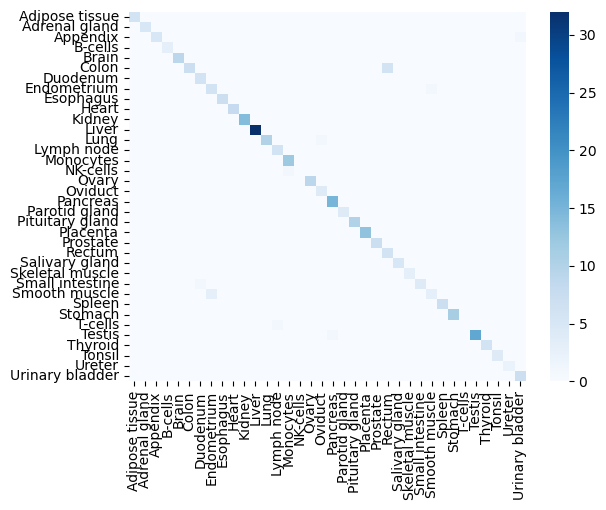

In [186]:
from sklearn.metrics import confusion_matrix, classification_report
model.eval()  # Set the model to evaluation mode
y_pred = []
y_true = []

with torch.no_grad():  # Disable gradient calculation for inference
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Get the predicted class (highest probability)
        y_pred.extend(predicted.numpy())      # Append predictions
        y_true.extend(labels.numpy())         # Append true labels

# Decode the labels
y_pred_decoded = label_encoder.inverse_transform(y_pred)
y_true_decoded = label_encoder.inverse_transform(y_true)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_decoded, y_pred_decoded)
sns.heatmap(conf_matrix, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')

In [187]:
import joblib

torch.save(model.state_dict(), './models/simpleNN.pth')

# Save the trained model
# joblib.dump(model.state_dict(), "./models/simpleNN.pth")
# print("Model saved successfully.")

# Save the feature names to a text file
with open("./models/simpleNN_features.txt", "w") as f:
    for feature in X_train.columns:  # Assuming X_train is a Pandas DataFrame
        f.write(f"{feature},\n")
print("Features saved successfully.")

#save the label encoder
joblib.dump(label_encoder, "./models/simpleNN_label_encoder.joblib")

Features saved successfully.


['./models/simpleNN_label_encoder.joblib']

In [193]:
testdf = pd.read_csv('/home/compomics/git/MLMarker/data/diseased_atlas_20240403.csv')
testdf = testdf[testdf['disease_status'] == 'Diseased']
#select 100 random rows
testdf = testdf.sample(n=100, random_state=42)
testlabels = testdf['tissue_name']
testdf = testdf.drop(['tissue_name', 'index', 'assay_id', 'cell_type', 'disease_status', 'fluid'], axis=1)

,A0A024RBG1,A0A075B6H7,A0A075B6H8,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I7,A0A075B6I9,A0A075B6J1,A0A075B6J6,...,Q9Y6X5,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y1,Q9Y6Y8,Q9Y6Y9,Q9Y6Z5,Q9Y6Z7,W5XKT8
1529,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
253,0.0,0.000361,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000278,0.000150,0.0,0.000000,0.0,0.000335,0.0,0.0,0.000000,0.0
458,0.0,0.000000,0.000000,0.000000,0.002000,0.004066,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000881,0.0
318,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
4367,0.0,0.001670,0.000000,0.000000,0.003176,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
319,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
1363,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
4728,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
90,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
550,0.0,0.003428,0.003399,0.003342,0.016298,0.000000,0.0,0.003399,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0


<Axes: >

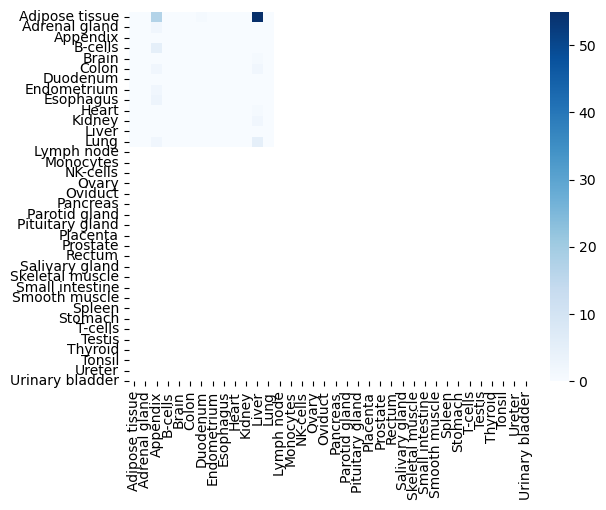

In [194]:
#apply the simpleNN model on testdf
testdf_subset = testdf[X_train.columns]
# Convert the data to PyTorch tensors
X_test_tensor = torch.tensor(testdf_subset.values, dtype=torch.float32)


#predict on the test data
model.eval()  # Set the model to evaluation mode
y_pred = []

with torch.no_grad():  # Disable gradient calculation for inference
    outputs = model(X_test_tensor)  # Forward pass
    _, predicted = torch.max(outputs, 1)  # Get the predicted class (highest probability)
    y_pred.extend(predicted.numpy())  # Convert to numpy and store predictions

# Decode the labels
y_pred_decoded = label_encoder.inverse_transform(y_pred)
y_true_decoded = testlabels

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_decoded, y_pred_decoded)
sns.heatmap(conf_matrix, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')



In [156]:
import shap
import torch
import numpy as np

# Assuming X_test_tensor_shap is your test data (shape [10, 11424])
X_test_tensor_shap = X_test_tensor[:10]  # Choose a batch or all test data
X_test_tensor_shap = X_test_tensor_shap.view(X_test_tensor_shap.size(0), -1)  # Ensure correct shape

# Create SHAP explainer using DeepExplainer, assuming the model is already trained
explainer = shap.DeepExplainer(model, X_train_tensor)  # Reference model with training data

# Get the SHAP values for the selected test data
shap_values = explainer.shap_values(X_test_tensor_shap)

# Get output dimension (number of classes)
output_dim = len(label_encoder.classes_)

# Define present vs absent features
present_features = X_test_tensor_shap != 0  # Identify non-zero features (present)
absent_features = X_test_tensor_shap == 0   # Identify zero features (absent)

# Convert to numpy for easier processing
present_features = present_features.numpy()  # Shape: (batch_size, num_features)
absent_features = absent_features.numpy()    # Shape: (batch_size, num_features)

# Initialize dictionaries to store SHAP values for each class
avg_shap_present = {i: [] for i in range(output_dim)}  # output_dim is the number of classes
avg_shap_absent = {i: [] for i in range(output_dim)}

# Iterate over each class (SHAP values for each class are stored separately)
for i in range(output_dim):  # Loop over each class
    for j in range(shap_values[i].shape[0]):  # Iterate over each sample
        # Extract SHAP values for present and absent features
        present_shap_values = shap_values[i][j][present_features[j]]  # SHAP values for present features
        absent_shap_values = shap_values[i][j][absent_features[j]]    # SHAP values for absent features
        
        # Calculate the average SHAP value for present vs absent features for each sample
        avg_shap_present[i].append(np.mean(present_shap_values) if present_shap_values.size > 0 else 0)
        avg_shap_absent[i].append(np.mean(absent_shap_values) if absent_shap_values.size > 0 else 0)

# Now calculate the overall average for each class
for i in range(output_dim):
    avg_shap_present[i] = np.mean(avg_shap_present[i])
    avg_shap_absent[i] = np.mean(avg_shap_absent[i])

# Output the results
for i in range(output_dim):
    print(f"Class {i}:")
    print(f"  Avg SHAP (present features): {avg_shap_present[i]:.4f}")
    print(f"  Avg SHAP (absent features): {avg_shap_absent[i]:.4f}")


RuntimeError: The size of tensor a (128) must match the size of tensor b (64) at non-singleton dimension 1

# Feature reduction

Let's first have a look at the correlation between the features

In [292]:
X_train.head()

,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6K5,A0A075B6Q5,A0A075B6R2,A0A075B6S4,A0A075B6S5,A0A087WSY6,...,Q9Y6V7,Q9Y6W3,Q9Y6W5,Q9Y6X0,Q9Y6X3,Q9Y6X5,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y8
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [293]:
#correlation matrix of X
corr = X_train.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=False, fmt=".2f", cmap="coolwarm")
plt.show()

KeyboardInterrupt: 

In [ ]:
corr.head()

,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6K5,A0A075B6Q5,A0A075B6R2,A0A075B6S4,A0A075B6S5,A0A087WSY6,...,Q9Y6V7,Q9Y6W3,Q9Y6W5,Q9Y6X0,Q9Y6X3,Q9Y6X5,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y8
A0A075B6H7,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.252901,NaN,...,-0.01495,-0.030152,0.041363,NaN,NaN,-0.026039,NaN,NaN,NaN,-0.037772
A0A075B6H9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0A075B6I0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0A075B6I1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0A075B6K5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


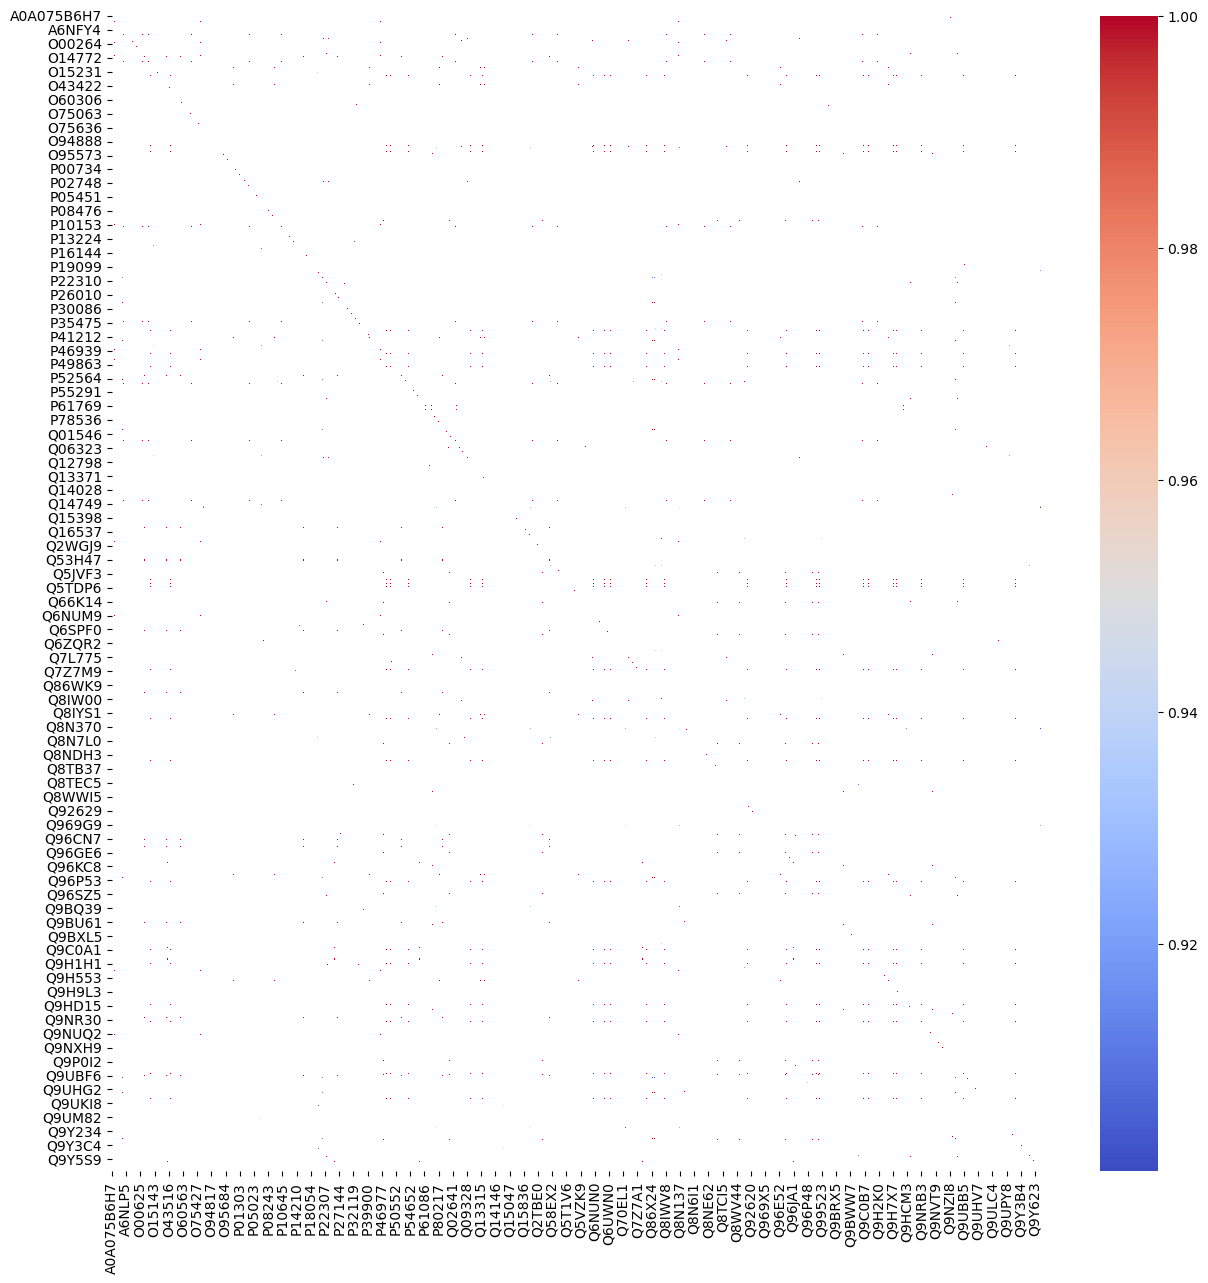

In [ ]:
corr_0_9 = corr[corr > 0.9]
plt.figure(figsize=(15, 15))
sns.heatmap(corr_0_9, annot=False, fmt=".2f", cmap="coolwarm")
plt.show()

There are a lot of features with a correlation above 0.9 with another feature. Meaning that we can drop one of the two features.

Let's have a look at a PCA plot

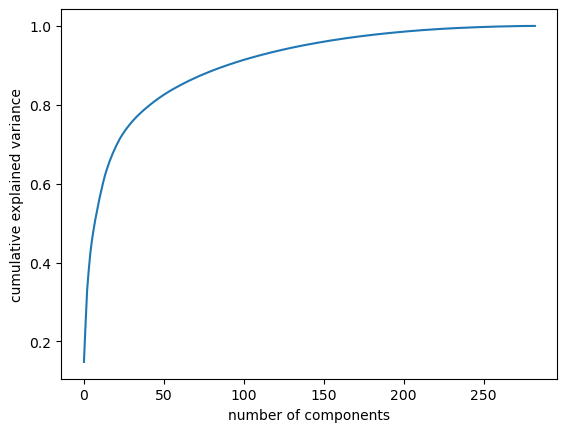

In [294]:
#make a PCA plot of the features and study the variance
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_train)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head()

pca.explained_variance_ratio_

pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');


Around a 200 PCA components explain 90% of the variance. This means that we can reduce the features a lot!

What ways of feature reduction can we use?
1. PCA
2. Feature selection
3. Feature importance
4. Feature correlation
5. Feature clustering
6. Feature extraction
7. Feature engineering


# XGB reduction

In [47]:
# define a function that takes X_train, y_train, X_test, y_test and returns a dataframe with the results
# it trains an xgboost model and validates it on the test set
def train_test_xgb(X_train, X_test, y_train, y_test, df, name):
    xgb= XGBClassifier(random_state=42, n_jobs=-1)
    xgb.fit(X_train, y_train)
    y_pred =  xgb.predict(X_test)
    fm = f1_score(y_test, y_pred, average="macro")
    fw = f1_score(y_test, y_pred, average="weighted")
    acc = accuracy_score(y_test, y_pred)
    pw = precision_score(y_test, y_pred, average='weighted')
    pm = precision_score(y_test, y_pred, average='macro')
    rw = recall_score(y_test, y_pred, average='weighted')
    rm = recall_score(y_test, y_pred, average='macro')
    df_length = len(df)
    df.loc[df_length] = [name, acc, fm, pw, rm, fw, pm, rw]  
    return df

### PCA

In [48]:
#1 PCA
# Select features using PCA to get 95% of the variance
perc = 0.95
pca = PCA(n_components=perc) #0.95 means that we want to include 95% of the variance
X_train_PCA = pca.fit_transform(X_train)
X_test_PCA = pca.transform(X_test)
print("original shape:   ", X_train.shape)
print("transformed shape:", X_train_PCA.shape)

#get column names of the selected features
selected_features_names = list(X_train.columns[pca.components_[0] != 0])
print(f"There were {len(selected_features_names)} features, combined in {X_train_PCA.shape[1]} components selected to address {perc*100}% of the variance")



NameError: name 'PCA' is not defined

In [ ]:
#use the selected features to train and test the model
result_df = train_test_xgb(X_train_PCA, X_test_PCA, y_train, y_test, result_df, 'XGB_PCA')
result_df

/home/compomics/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:46:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/compomics/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,model,Accuracy,f1_macro,precision_macro,recall_macro,f1_weighted,precision_weighted,recall_weighted
0,RandomForest_baseline,0.972973,0.889855,0.876812,0.913043,0.963063,0.876812,0.972973
1,RandomForest_optimised,0.986486,0.942029,0.934783,0.956522,0.981982,0.934783,0.986486
2,XGB_PCA,0.864865,0.725274,0.861261,0.752899,0.852341,0.721739,0.864865


The F1 score drops dramatically using this approach so that is definitely not the best one to go with. 

### Feature selection

In [ ]:
#train baseline xgb
xgb= XGBClassifier(random_state=42, n_jobs=-1)
xgb.fit(X_train, y_train)

#get feature importances
importances = xgb.feature_importances_

#feature selection based on feature importance
thresholds = np.sort(importances)

NameError: name 'XGBClassifier' is not defined

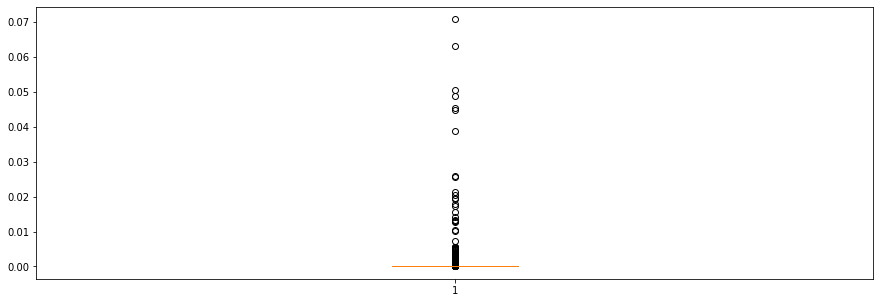

In [ ]:
#make a boxplot of thresholds
plt.figure(figsize=(15, 5))
plt.boxplot(thresholds)
plt.show()

In [ ]:
#Describe the thresholds, what is the cutoff for the quartiles?
#how many non zeroes are there in the feature importances?
print("Number of non-zero features: ", np.count_nonzero(importances))
#what is the smallest value in thresholds that is not zero?
print(f"The smallest value in thresholds that is not zero is {thresholds[thresholds != 0][0]}")

Number of non-zero features:  512
The smallest value in thresholds that is not zero is 6.932072210474871e-06


In [ ]:
#train an xgb with the non zero features
selection = SelectFromModel(xgb, threshold=0.0001, prefit=True)
select_X_train = selection.transform(X_train)

In [ ]:
smallest = thresholds[thresholds != 0][0]
selection = SelectFromModel(xgb, threshold=smallest, prefit=True)
select_X_train = selection.transform(X_train)
# train model
selection_model = XGBClassifier(random_state=42, n_jobs=-1)
selection_model.fit(select_X_train, y_train)
print(f"The cutoff at {smallest} resulted in the selection of {select_X_train.shape[1]} features ")
# eval model
select_X_test = selection.transform(X_test)
y_pred = selection_model.predict(select_X_test)
fm = f1_score(y_test, y_pred, average="macro")
fw = f1_score(y_test, y_pred, average="weighted")
acc = accuracy_score(y_test, y_pred)
pw = precision_score(y_test, y_pred, average='weighted')
pm = precision_score(y_test, y_pred, average='macro')
rw = recall_score(y_test, y_pred, average='weighted')
rm = recall_score(y_test, y_pred, average='macro')
df_length = len(result_df)
result_df.loc[df_length] = [f'XGB_feature_importance_smallest_nonzero{smallest}', acc, fm, pw, rm, fw, pm, rw]

/home/compomics/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:47:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The cutoff at 6.932072210474871e-06 resulted in the selection of 512 features 


/home/compomics/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
result_df

,model,Accuracy,f1_macro,precision_macro,recall_macro,f1_weighted,precision_weighted,recall_weighted
0,RandomForest_baseline,0.961039,0.898549,0.894669,0.912998,0.949976,0.894669,0.961039
1,XGB_baseline,0.883117,0.723825,0.709415,0.749633,0.854133,0.709415,0.883117
2,XGB_baseline_noweights,0.883117,0.723825,0.709415,0.749633,0.854133,0.709415,0.883117
3,XGB_PCA,0.850649,0.678607,0.827598,0.719916,0.829163,0.668350,0.850649
4,XGB_feature_importance_smallest_nonzero6.93207...,0.883117,0.723825,0.836514,0.749633,0.854133,0.709415,0.883117


So the XGB classifier actually only uses 515 features to achieve a classification with an f1 of 71%!
Let's see what happens to the correlation matrix if we only take those into account

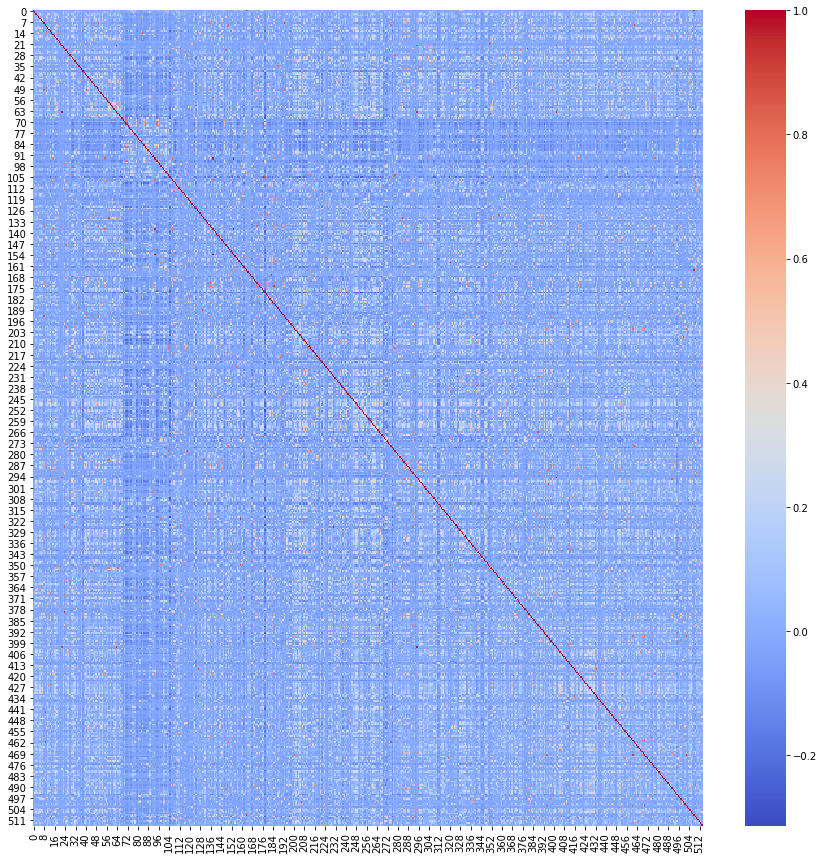

In [ ]:
#correlation matrix of X
corr_XGB_select = pd.DataFrame(select_X_train).corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr_XGB_select, annot=False, fmt=".2f", cmap="coolwarm")
plt.show()

# RF reduction

In general, the RF has a better F1 then the XGB so let's do the same for that. How many features have an importance above 0?

In [213]:
#train a baseline RandomForest_opt
forest_opt.fit(X_train, y_train)
baseline_predictions =  forest_opt.predict(X_test)
#print accuracy and f1 score
fm = f1_score(y_test, baseline_predictions, average="macro")
fw = f1_score(y_test, baseline_predictions, average="weighted")
acc = accuracy_score(y_test, baseline_predictions)
print("Accuracy: %.2f%%" % (acc * 100.0))
print("f1 macro: %.2f%%" % (fm * 100.0))
print("f1 weighted: %.2f%%" % (fw * 100.0))
#get the feature importances
importances = forest_opt.feature_importances_

#how many non zeroes are there in the feature importances?
print("Number of non-zero features: ", np.count_nonzero(importances))
#what is the smallest value in thresholds that is not zero?
print(f"The smallest value in thresholds that is not zero is {importances[importances != 0][0]}")

Accuracy: 95.50%
f1 macro: 91.33%
f1 weighted: 95.13%
Number of non-zero features:  8725
The smallest value in thresholds that is not zero is 0.00017881345645038194


array([0.00000000e+00, 1.78813456e-04, 1.47138799e-05, ...,
       4.38175918e-06, 6.96178836e-06, 0.00000000e+00])

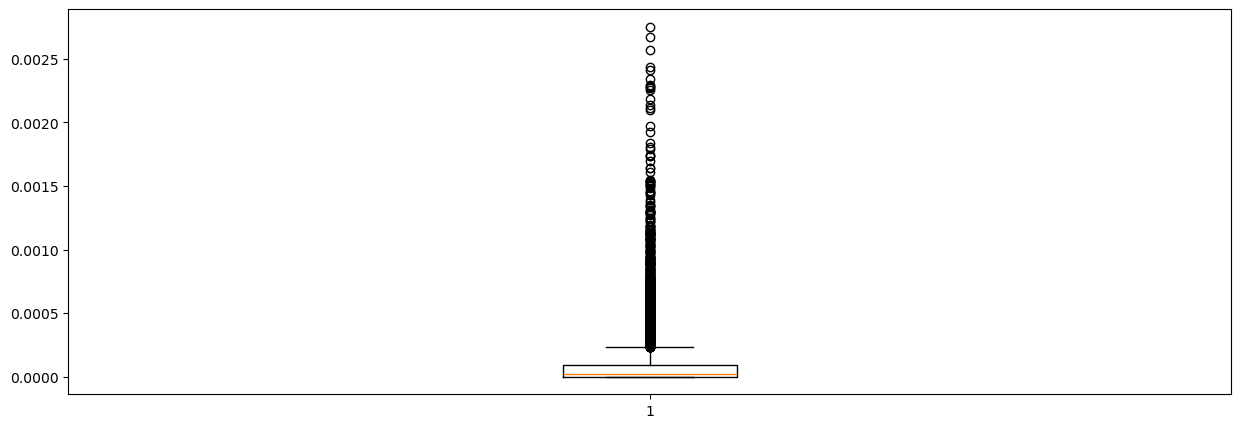

In [201]:
#Now we will use the feature importances to select features
# Select features using threshold
thresholds = np.sort(importances)
#make a boxplot of thresholds
plt.figure(figsize=(15, 5))
plt.boxplot(thresholds)
plt.show()

In [207]:
# Going over the highest 10%, 20%, 30% etc. of the features
# Train and evaluate a RandomForest
plot_df = pd.DataFrame(columns=['Percentage', 'Features', 'f1_macro', 'f1_weighted', 'accuracy'])
for perc in [0.01, 0.02, 0.03, 0.04, 0.05, 0.1,0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.75, 1]: #highest 10%, 20%
    smallest = thresholds[int(len(thresholds)*(1-perc))]
    print(f"The cutoff at {smallest} resulted in the selection of {len(thresholds[thresholds > smallest])} features ")
    selection = SelectFromModel(forest_opt, threshold=smallest, prefit=True)
    select_X_train = selection.transform(X_train)
    print(f"Threshold {perc} resulted in {select_X_train.shape[1]} features")
    # train model
    selection_model = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
    selection_model.fit(select_X_train, y_train, sample_weight=sample_weights)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    fm = f1_score(y_test, y_pred, average="macro")
    fw = f1_score(y_test, y_pred, average="weighted")
    acc = accuracy_score(y_test, y_pred)
    pw = precision_score(y_test, y_pred, average='weighted')
    pm = precision_score(y_test, y_pred, average='macro')
    rw = recall_score(y_test, y_pred, average='weighted')
    rm = recall_score(y_test, y_pred, average='macro')
    df_length = len(result_df)
    result_df.loc[df_length] = [f'RandomForest_feature_importance_{perc}', acc, fm, pw, rm, fw, pm, rw]
    plot_df.loc[len(plot_df)] = [perc, select_X_train.shape[1], fm, fw, acc]

The cutoff at 0.0009554012332594305 resulted in the selection of 114 features 


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold 0.01 resulted in 115 features


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has featu

The cutoff at 0.000656680008493192 resulted in the selection of 228 features 
Threshold 0.02 resulted in 229 features


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has featu

The cutoff at 0.0005162008354756797 resulted in the selection of 342 features 
Threshold 0.03 resulted in 343 features


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has featu

The cutoff at 0.0004341089259558363 resulted in the selection of 456 features 
Threshold 0.04 resulted in 457 features


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has featu

The cutoff at 0.0003732552709012719 resulted in the selection of 570 features 
Threshold 0.05 resulted in 571 features


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has featu

The cutoff at 0.00022582934473450972 resulted in the selection of 1141 features 
Threshold 0.1 resulted in 1142 features


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has featu

The cutoff at 0.00012374029894922508 resulted in the selection of 2283 features 
Threshold 0.2 resulted in 2284 features


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has featu

The cutoff at 9.503344678462047e-05 resulted in the selection of 2854 features 
Threshold 0.25 resulted in 2855 features


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has featu

The cutoff at 7.203381806050651e-05 resulted in the selection of 3426 features 
Threshold 0.3 resulted in 3427 features


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


The cutoff at 5.367337937740363e-05 resulted in the selection of 3996 features 


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold 0.35 resulted in 3997 features


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has featu

The cutoff at 3.940002633120572e-05 resulted in the selection of 4567 features 
Threshold 0.4 resulted in 4568 features


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has featu

The cutoff at 2.841866610172144e-05 resulted in the selection of 5138 features 
Threshold 0.45 resulted in 5139 features


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has featu

The cutoff at 1.9928358824288384e-05 resulted in the selection of 5709 features 
Threshold 0.5 resulted in 5710 features


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has featu

The cutoff at 1.37953319886463e-06 resulted in the selection of 8564 features 
Threshold 0.75 resulted in 8565 features


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has featu

The cutoff at 0.0 resulted in the selection of 8725 features 
Threshold 1 resulted in 11420 features


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [208]:
plot_df

,Percentage,Features,f1_macro,f1_weighted,accuracy
0,0.01,115.0,0.896265,0.938674,0.941176
1,0.02,229.0,0.946168,0.974723,0.975779
2,0.03,343.0,0.927035,0.960454,0.961938
3,0.04,457.0,0.928051,0.963303,0.965398
4,0.05,571.0,0.929356,0.963926,0.965398
5,0.10,1142.0,0.920831,0.955084,0.958478
6,0.20,2284.0,0.912278,0.949052,0.951557
7,0.25,2855.0,0.886374,0.930900,0.934256
8,0.30,3427.0,0.948440,0.952627,0.955017
9,0.35,3997.0,0.904854,0.945264,0.948097


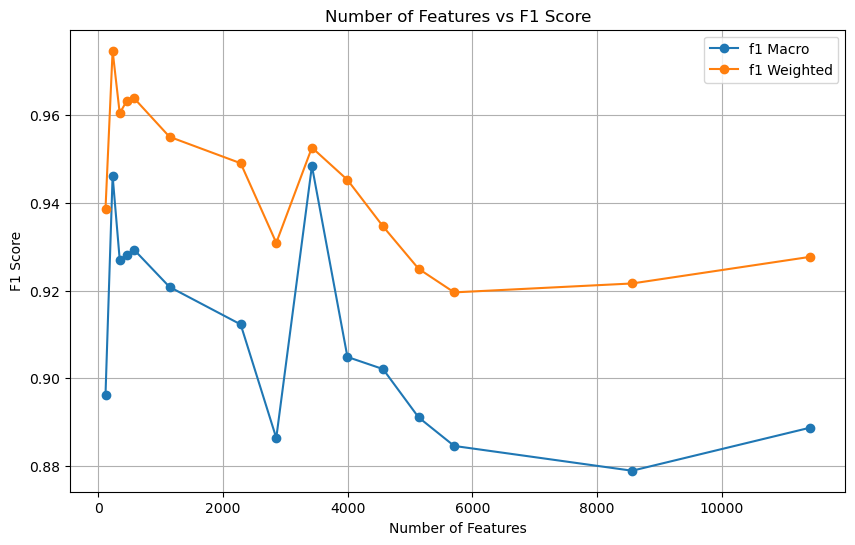

In [209]:
plt.figure(figsize=(10, 6))
plt.plot(plot_df['Features'], plot_df['f1_macro'], marker='o', label='f1 Macro')
plt.plot(plot_df['Features'], plot_df['f1_weighted'], marker='o', label='f1 Weighted')
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.title('Number of Features vs F1 Score')
plt.legend()
plt.grid(True)
plt.show()

Highest performance is with the top 10% of the features 688.0 features, 0.955556 f1n macro,0.983007 f1 weighted	0.988235 accuracy

In [210]:
#Just do the 4% RF
perc=0.3
smallest = thresholds[int(len(thresholds)*(1-perc))]
print(f"The cutoff at {smallest} resulted in the selection of {len(thresholds[thresholds > smallest])} features ")
selection = SelectFromModel(forest_opt, threshold=smallest, prefit=True)
select_X_train_RF = selection.transform(X_train)
print(f"Threshold {perc} resulted in {select_X_train_RF.shape[1]} features")
# train model
selection_model = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
selection_model.fit(select_X_train_RF, y_train, sample_weight=sample_weights)
# eval model
select_X_test_RF = selection.transform(X_test)
y_pred = selection_model.predict(select_X_test_RF)
fm = f1_score(y_test, y_pred, average="macro")
fw = f1_score(y_test, y_pred, average="weighted")
acc = accuracy_score(y_test, y_pred)
pw = precision_score(y_test, y_pred, average='weighted')
pm = precision_score(y_test, y_pred, average='macro')
rw = recall_score(y_test, y_pred, average='weighted')
rm = recall_score(y_test, y_pred, average='macro')
df_length = len(result_df)
result_df.loc[df_length] = [f'RandomForest_feature_importance_{perc}', acc, fm, pw, rm, fw, pm, rw]

The cutoff at 7.203381806050651e-05 resulted in the selection of 3426 features 


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold 0.3 resulted in 3427 features


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [219]:
selected_feature_names = X_train.columns[selection.get_support()]
print(selected_feature_names)

Index(['A0A075B6H7', 'A0A075B6I0', 'A0A075B6Q5', 'A0A075B6R2', 'A0A075B6S5',
       'A0A0A0MS14', 'A0A0A0MS15', 'A0A0B4J1U3', 'A0A0B4J1U7', 'A0A0B4J1V0',
       ...
       'Q9Y6Q1', 'Q9Y6R1', 'Q9Y6U3', 'Q9Y6V0', 'Q9Y6W3', 'Q9Y6W5', 'Q9Y6W6',
       'Q9Y6X5', 'Q9Y6X8', 'Q9Y6Y8'],
      dtype='object', length=3427)


In [220]:
from joblib import dump

# Specify the file path where you want to save the joblib file
file_path = '/home/compomics/git/MLMarker/models/binary_RF_minimalfeatureset_20241001.joblib'
dump(selection_model, file_path)

np.savetxt('/home/compomics/git/MLMarker/models/binary_features_RF_minimalfeatureset_20241001.txt', selected_feature_names, fmt='%s,')


In [53]:
rf_vs =  OneVsRestClassifier(selection_model).fit(select_X_train_RF, y_train)
feature_names = X.columns
classes = selection_model.classes_   
for i in range(len(rf_vs.estimators_)): 
    pred_class = classes[i]
    print(pred_class)
    pred = rf_vs.estimators_[i]
    importances = pred.feature_importances_
    std = np.std([tree.feature_importances_ for tree in pred.estimators_],axis=0) #compute standard deviation of the feature importance over all the DecisionTreeClassifiers in the Random Forest
    
    rf_features_df = pd.DataFrame(columns=['feature_name', 'importance', 'standard deviation'])
    for f in range(select_X_train_RF.shape[1]):
        rf_features_df.loc[f] = [feature_names[f], importances[f], std[f]]
    values = (rf_features_df['importance'] != 0).sum()
    rf_features_df.to_csv('/home/compomics/git/Tissue_prediction/PTM_predictor/Output/Feature_importances_minimalfeatureset_tissueclassification_20240219/{}.csv'.format(pred_class))
    print('{} contains {} not-zero features'.format(pred_class, values))


Adrenal gland
Adrenal gland contains 207 not-zero features
B-cells
B-cells contains 263 not-zero features
Bone
Bone contains 186 not-zero features
Brain
Brain contains 249 not-zero features
Colon
Colon contains 248 not-zero features
Esophagus
Esophagus contains 194 not-zero features
Gall bladder
Gall bladder contains 215 not-zero features
Heart
Heart contains 245 not-zero features
Kidney
Kidney contains 254 not-zero features
Liver
Liver contains 222 not-zero features
Lung
Lung contains 251 not-zero features
Monocytes
Monocytes contains 178 not-zero features
NK-cells
NK-cells contains 179 not-zero features
Nasal polyps
Nasal polyps contains 180 not-zero features
Ovary
Ovary contains 401 not-zero features
Pancreas
Pancreas contains 217 not-zero features
Parotid gland
Parotid gland contains 170 not-zero features
Placenta
Placenta contains 207 not-zero features
Prostate
Prostate contains 184 not-zero features
Skeletal muscle
Skeletal muscle contains 194 not-zero features
Small intestine
Sm

In [41]:
result_df

,model,Accuracy,f1_macro,precision_macro,recall_macro,f1_weighted,precision_weighted,recall_weighted
0,RandomForest_baseline,0.976471,0.908364,0.900000,0.92,0.966417,0.900000,0.976471
1,RandomForest_feature_importance_0.01,0.952941,0.838667,0.934174,0.86,0.938431,0.835238,0.952941
2,RandomForest_feature_importance_0.02,0.976471,0.902222,0.961176,0.92,0.967320,0.892000,0.976471
3,RandomForest_feature_importance_0.03,0.976471,0.912000,0.960784,0.92,0.967059,0.906667,0.976471
4,RandomForest_feature_importance_0.04,0.976471,0.912727,0.956863,0.92,0.965775,0.906667,0.976471
5,RandomForest_feature_importance_0.05,0.976471,0.912000,0.960784,0.92,0.967059,0.906667,0.976471
6,RandomForest_feature_importance_0.1,0.988235,0.955556,0.978824,0.96,0.983007,0.952000,0.988235
7,RandomForest_feature_importance_0.2,0.988235,0.955556,0.978824,0.96,0.983007,0.952000,0.988235
8,RandomForest_feature_importance_0.25,0.988235,0.955556,0.978824,0.96,0.983007,0.952000,0.988235
9,RandomForest_feature_importance_0.3,0.976471,0.908364,0.958824,0.92,0.966417,0.900000,0.976471


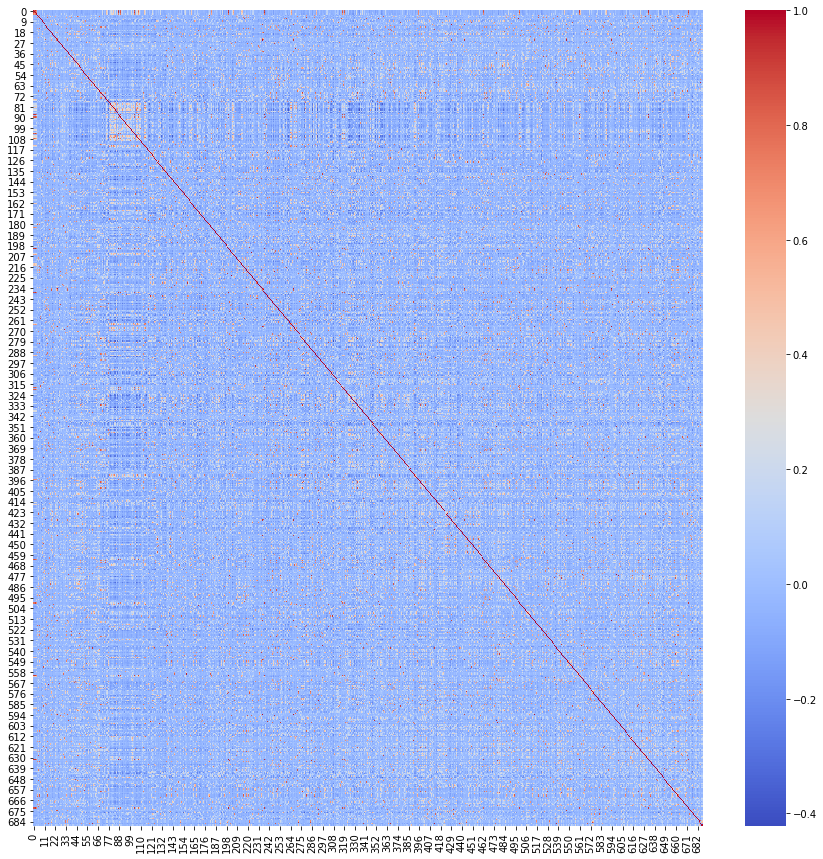

In [42]:
#correlation matrix of subset of RF features
corr_RF_select = pd.DataFrame(select_X_train_RF).corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr_RF_select, annot=False, fmt=".2f", cmap="coolwarm")
plt.show()

RF is better compared to XGB but has more highly correlating features so there might be some redundancy there. Although 688 features is not bad! Let's dig deeper in to them

In [50]:
import pandas as pd

# Set the display option to print without truncation
pd.set_option('display.max_colwidth', None)

selected_features = X_train.columns[selection.get_support()]
for feature in selected_features:
    print(feature)


A0A075B6I0
A0A0C4DH29
A0A0C4DH31
A0A0C4DH38
A5A3E0
A6NHL2
A6NHZ5
A8K2U0
O00151
O00160
O00264
O00468
O14494
O14594
O14975
O14983
O15020
O15061
O15117
O15127
O15143
O15335
O15460
O15498
O43581
O43692
O43707
O43813
O43895
O60218
O60240
O60343
O60565
O60568
O60662
O60829
O60844
O60869
O75083
O75112
O75339
O75380
O75427
O75438
O75533
O75582
O75791
O75792
O75874
O75891
O75915
O75937
O76031
O76041
O94804
O94819
O94925
O95169
O95197
O95274
O95425
O95674
O95810
O95816
O95817
O95831
O95833
O95865
O95881
O95954
P00326
P00338
P00352
P00403
P00480
P00488
P00491
P00505
P00742
P00747
P01008
P01009
P01019
P01023
P01024
P01034
P01042
P01275
P01599
P01619
P01700
P01833
P01871
P02042
P02452
P02533
P02549
P02675
P02730
P02743
P02748
P02749
P02760
P02763
P02765
P02775
P02787
P02790
P03973
P04003
P04004
P04066
P04080
P04179
P04196
P04217
P04275
P04279
P04350
P04406
P04746
P04792
P04843
P04844
P05023
P05026
P05091
P05109
P05120
P05164
P05186
P05386
P05387
P05451
P05556
P05783
P05787
P05976
P06127
P06396
P065